# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block8_10_conv', 'conv_7b']
    LAST_LAYER = 'conv_7b'
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7963 - accuracy: 0.7341

947/947 [==============================] - 3485s 4s/step - loss: 0.7963 - accuracy: 0.7341 - val_loss: 0.7164 - val_accuracy: 0.7543
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.7607

947/947 [==============================] - 3423s 4s/step - loss: 0.6959 - accuracy: 0.7607 - val_loss: 0.6935 - val_accuracy: 0.7693
Epoch 3/200
947/947 [==============================] - 3143s 3s/step - loss: 0.6363 - accuracy: 0.7768 - val_loss: 0.8115 - val_accuracy: 0.7254
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7883

947/947 [==============================] - 3044s 3s/step - loss: 0.6043 - accuracy: 0.7883 - val_loss: 0.6629 - val_accuracy: 0.7777
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7959

947/947 [==============================] - 2746s 3s/step - loss: 0.5809 - accuracy: 0.7959 - val_loss: 0.6257 - val_accuracy: 0.7870
Epoch 6/200
947/947 [==============================] - 2459s 3s/step - loss: 0.5570 - accuracy: 0.8053 - val_loss: 0.7455 - val_accuracy: 0.7494
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.8092

947/947 [==============================] - 2526s 3s/step - loss: 0.5319 - accuracy: 0.8092 - val_loss: 0.5178 - val_accuracy: 0.8171
Epoch 8/200
947/947 [==============================] - 2392s 3s/step - loss: 0.5113 - accuracy: 0.8198 - val_loss: 0.5832 - val_accuracy: 0.7947
Epoch 9/200
947/947 [==============================] - 2420s 3s/step - loss: 0.4995 - accuracy: 0.8220 - val_loss: 6.6219 - val_accuracy: 0.5953
Epoch 10/200
947/947 [==============================] - 2411s 3s/step - loss: 0.4849 - accuracy: 0.8244 - val_loss: 0.6670 - val_accuracy: 0.7689
Epoch 11/200
947/947 [==============================] - 2376s 3s/step - loss: 0.4684 - accuracy: 0.8315 - val_loss: 0.5649 - val_accuracy: 0.8080
Epoch 12/200
947/947 [==============================] - 2399s 3s/step - loss: 0.4504 - accuracy: 0.8375 - val_loss: 0.5356 - val_accuracy: 0.8087
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8405

947/947 [==============================] - 2474s 3s/step - loss: 0.4382 - accuracy: 0.8405 - val_loss: 0.5054 - val_accuracy: 0.8188
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8486

947/947 [==============================] - 2464s 3s/step - loss: 0.4198 - accuracy: 0.8486 - val_loss: 0.4932 - val_accuracy: 0.8229
Epoch 15/200
947/947 [==============================] - 2365s 2s/step - loss: 0.4058 - accuracy: 0.8547 - val_loss: 0.7697 - val_accuracy: 0.7826
Epoch 16/200
947/947 [==============================] - 2370s 3s/step - loss: 0.3914 - accuracy: 0.8601 - val_loss: 0.4936 - val_accuracy: 0.8299
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8601

947/947 [==============================] - 2491s 3s/step - loss: 0.3822 - accuracy: 0.8601 - val_loss: 0.4875 - val_accuracy: 0.8255
Epoch 18/200
947/947 [==============================] - 2352s 2s/step - loss: 0.3666 - accuracy: 0.8654 - val_loss: 0.5495 - val_accuracy: 0.8151
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8702

947/947 [==============================] - 2457s 3s/step - loss: 0.3560 - accuracy: 0.8702 - val_loss: 0.4711 - val_accuracy: 0.8332
Epoch 20/200
947/947 [==============================] - 2345s 2s/step - loss: 0.3595 - accuracy: 0.8696 - val_loss: 0.5044 - val_accuracy: 0.8208
Epoch 21/200
947/947 [==============================] - 2397s 3s/step - loss: 0.3342 - accuracy: 0.8775 - val_loss: 0.4755 - val_accuracy: 0.8369
Epoch 22/200
947/947 [==============================] - 2340s 2s/step - loss: 0.3259 - accuracy: 0.8801 - val_loss: 17.5554 - val_accuracy: 0.0905
Epoch 23/200
947/947 [==============================] - 2350s 2s/step - loss: 0.3196 - accuracy: 0.8833 - val_loss: 0.7366 - val_accuracy: 0.7369
Epoch 24/200
947/947 [==============================] - 2339s 2s/step - loss: 0.2975 - accuracy: 0.8919 - val_loss: 0.4851 - val_accuracy: 0.8292
Epoch 25/200
947/947 [==============================] - 2338s 2s/step - loss: 0.2941 - accuracy: 0.8927 - val_loss: 0.4978 - val_accurac

947/947 [==============================] - 2451s 3s/step - loss: 0.2838 - accuracy: 0.8957 - val_loss: 0.4704 - val_accuracy: 0.8404
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8989

947/947 [==============================] - 2454s 3s/step - loss: 0.2756 - accuracy: 0.8989 - val_loss: 0.4341 - val_accuracy: 0.8529
Epoch 28/200
947/947 [==============================] - 2341s 2s/step - loss: 0.2636 - accuracy: 0.9014 - val_loss: 0.4691 - val_accuracy: 0.8431
Epoch 29/200
947/947 [==============================] - 2347s 2s/step - loss: 0.2448 - accuracy: 0.9103 - val_loss: 0.4447 - val_accuracy: 0.8526
Epoch 30/200
947/947 [==============================] - 2341s 2s/step - loss: 0.2372 - accuracy: 0.9128 - val_loss: 0.5812 - val_accuracy: 0.8089
Epoch 31/200
947/947 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9120

947/947 [==============================] - 2462s 3s/step - loss: 0.2383 - accuracy: 0.9120 - val_loss: 0.4220 - val_accuracy: 0.8633
Epoch 32/200
947/947 [==============================] - 2344s 2s/step - loss: 0.2208 - accuracy: 0.9175 - val_loss: 0.5012 - val_accuracy: 0.8430
Epoch 33/200
947/947 [==============================] - 2340s 2s/step - loss: 0.2134 - accuracy: 0.9213 - val_loss: 0.4632 - val_accuracy: 0.8556
Epoch 34/200
947/947 [==============================] - 2336s 2s/step - loss: 0.2106 - accuracy: 0.9217 - val_loss: 0.5246 - val_accuracy: 0.8375
Epoch 35/200
947/947 [==============================] - 2357s 2s/step - loss: 0.1959 - accuracy: 0.9250 - val_loss: 0.5061 - val_accuracy: 0.8521
Epoch 36/200
947/947 [==============================] - 2331s 2s/step - loss: 0.1900 - accuracy: 0.9283 - val_loss: 0.5106 - val_accuracy: 0.8452
Epoch 37/200
947/947 [==============================] - 2352s 2s/step - loss: 0.1836 - accuracy: 0.9337 - val_loss: 0.5422 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 255s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.967288507801982,
 'basal cell carcinoma': 0.9861864737383409,
 'dermatofibroma': 0.9475501895268846,
 'melanoma': 0.9373970345963756,
 'nevus': 0.9705850552831867,
 'pigmented benign keratosis': 0.9840826995510072,
 'seborrheic keratosis': 0.961474549048678,
 'solar lentigo': 0.97334229390681,
 'squamous cell carcinoma': 0.9822282681714363,
 'vascular lesion': 0.9995708225351182}

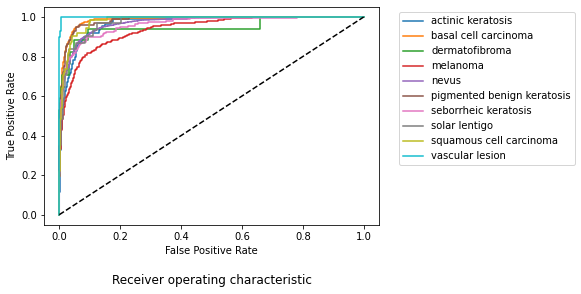

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

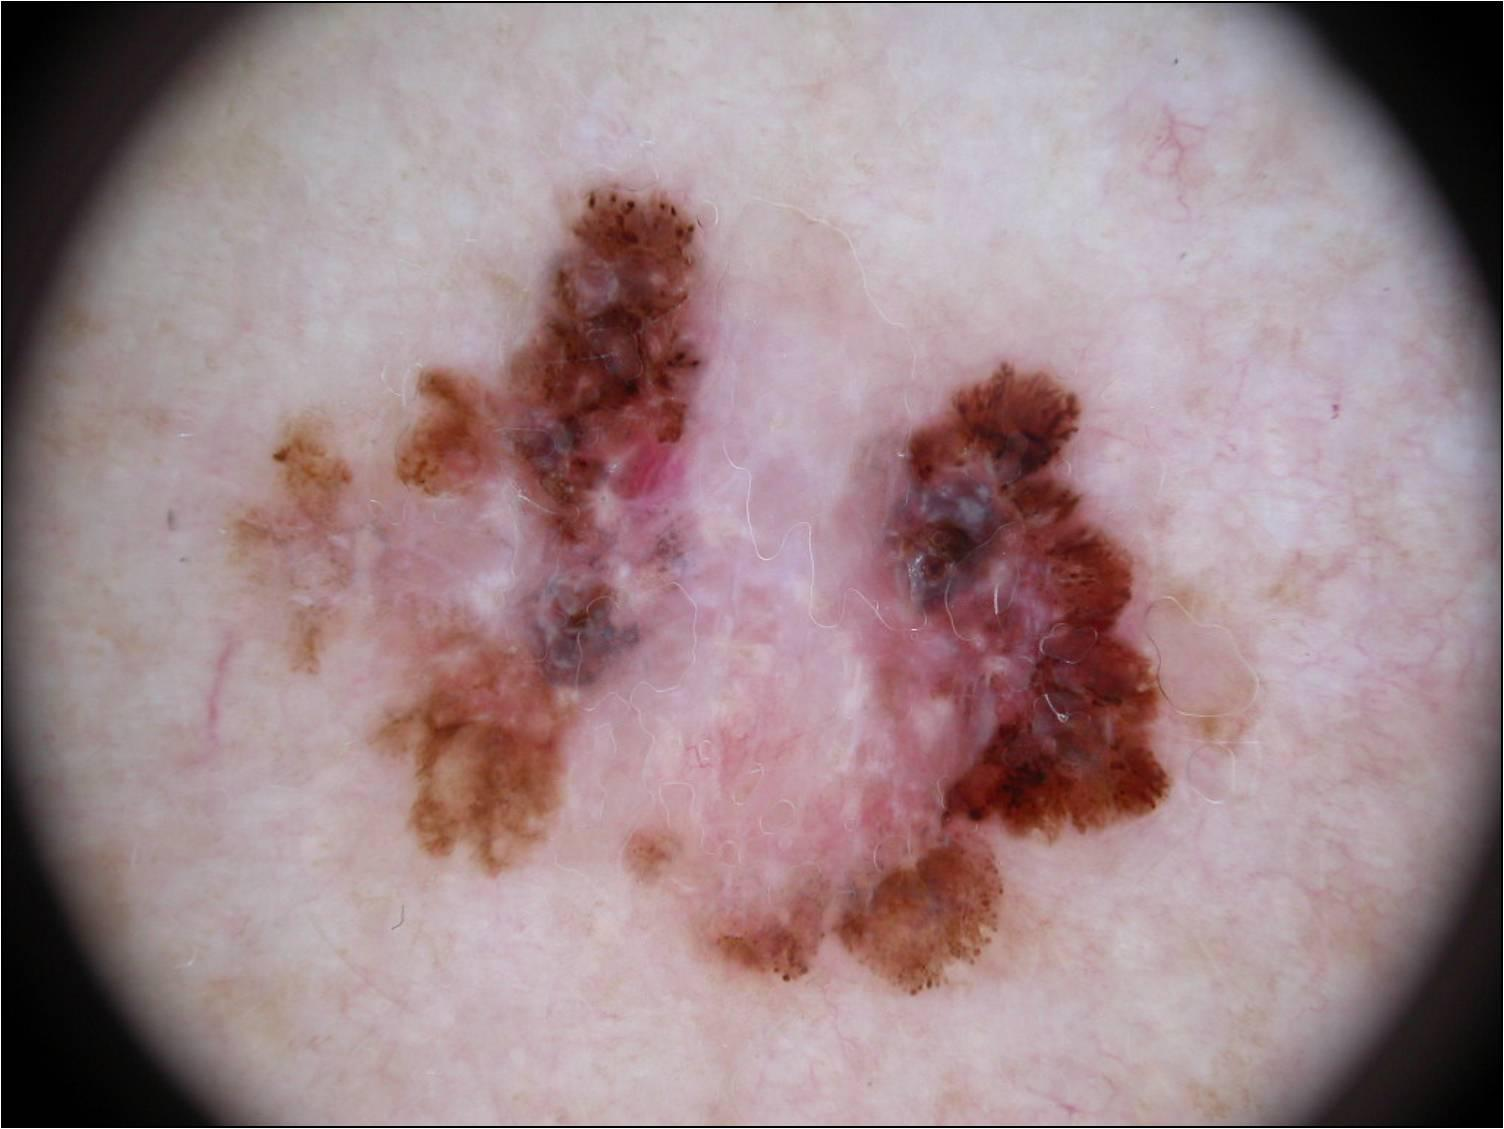

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

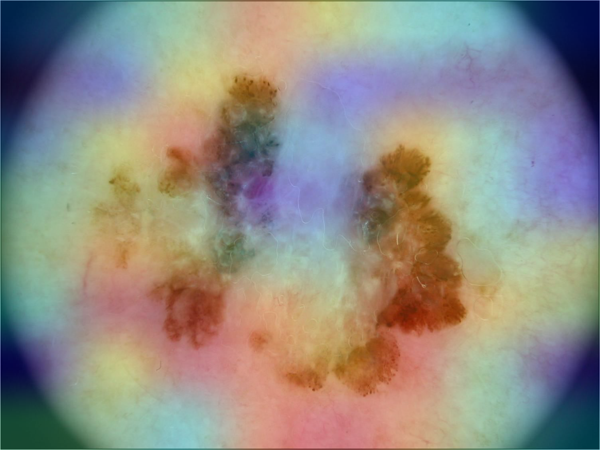

In [23]:
display_gradcam(melanoma_im_path, heatmap)